# Principal Component Analysis

We will be introducing principal component analysis (PCA), which is one of the most commonly used and simplest data analysis techniques. It is a straightforward application of Singular Value Decomposition (SVD), so this also serves to show a practical application of SVD. 

## Problem statement

Suppose we have a data set that consists of $N$ instances of something, and each instance has $M$ attributes. We would like to understand this dataset better: in which attribute do a lot of the instances differ the most? Are there groups of instances which share similar attributes? Can we summarise the data better by combining several attributes together? Principal component analysis provides a simple answer to all of these questions. The key word is "simple" here, in fact all relationships that PCA lets you discover are _linear_ in the original attributes. There might be more complex relationships which are beyond PCA or require kernel PCA. 

To make it concrete, let us examine a data set from [UC Irvine Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php), specifically one on the [vertebral column](http://archive.ics.uci.edu/ml/datasets/Vertebral+Column). Each instance is a patient, the six features correspond to six biomechanical attributes. Some of the patients are healthy ("normal"), others have either disk hernia or spondilolysthesis. The data analysis task is ultimately to learn if the biomechanical features are predictors of the health status, and if so, which ones or which combinations. 


## Importing the data

We will load the data into a matrix $X$, in which each row corresponds to a patient, and each column corresponds one of the six biomechanical features: pelvic incidence, pelvic tilt, lumbar lordosis angle, sacral slope, pelvic radius and grade of spondylolisthesis. The elements of the matrix are real numbers. 

In [ ]:
import numpy as np # First we load the Python library that helps with manipulating data
import matplotlib.pyplot as plt


In [6]:
X = np.genfromtxt('vertebral_column_data.csv', delimiter=',') # the data is in a CVS file

Let's find out how many patients we have, and confirm that there are indeed six features

In [7]:
X.shape #Inspect shape

(310, 7)

The ".shape" attribute of a matrix is a "tuple", in this case a pair of numbers, the first shows the number of rows, the second shows the number of columns. So why are there 7 columns?? The last one is the diagnosis made by a doctor, with a "1" corresponding to "disk hernia", "2" corresponding to "spondilolysthesis", and "3" corresponding to "normal". Let us examine some elements of the matrix.

In [8]:
X[:20][:] #Inspect all features/class of first 20 patients

array([[ 63.03,  22.55,  39.61,  40.48,  98.67,  -0.25,   1.  ],
       [ 39.06,  10.06,  25.02,  29.  , 114.41,   4.56,   1.  ],
       [ 68.83,  22.22,  50.09,  46.61, 105.99,  -3.53,   1.  ],
       [ 69.3 ,  24.65,  44.31,  44.64, 101.87,  11.21,   1.  ],
       [ 49.71,   9.65,  28.32,  40.06, 108.17,   7.92,   1.  ],
       [ 40.25,  13.92,  25.12,  26.33, 130.33,   2.23,   1.  ],
       [ 53.43,  15.86,  37.17,  37.57, 120.57,   5.99,   1.  ],
       [ 45.37,  10.76,  29.04,  34.61, 117.27, -10.68,   1.  ],
       [ 43.79,  13.53,  42.69,  30.26, 125.  ,  13.29,   1.  ],
       [ 36.69,   5.01,  41.95,  31.68,  84.24,   0.66,   1.  ],
       [ 49.71,  13.04,  31.33,  36.67, 108.65,  -7.83,   1.  ],
       [ 31.23,  17.72,  15.5 ,  13.52, 120.06,   0.5 ,   1.  ],
       [ 48.92,  19.96,  40.26,  28.95, 119.32,   8.03,   1.  ],
       [ 53.57,  20.46,  33.1 ,  33.11, 110.97,   7.04,   1.  ],
       [ 57.3 ,  24.19,  47.  ,  33.11, 116.81,   5.77,   1.  ],
       [ 44.32,  12.54,  

Not all elements are printed, just a few. We can inspect a given row, for example the first one, corresponding to the first patient.

In [9]:
X[0,:] #First patient

array([63.03, 22.55, 39.61, 40.48, 98.67, -0.25,  1.  ])

## Basic plotting

We don't get very far in comprehending even this small data set by just looking at the numbers. So let us plot a few a few things. For example, we can make a scatterplot of all the patiants, using the first two attributes as x and y axes.

In [10]:
from pylab import * # import some shortcuts to plotting functionality

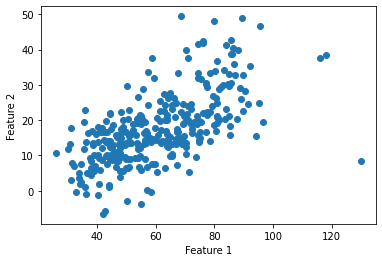

In [12]:
#Plot a scatter comparing first and second features
scatter(X[:,0], X[:,1]) 
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

It is clear that there are big variations in the first two attributes, and they are not entirely uncorrelated. Here is the same for the third and fourth:

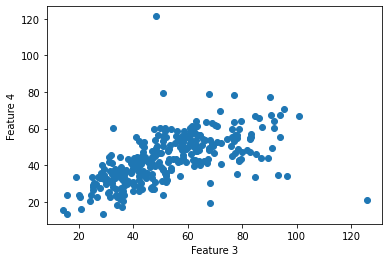

In [13]:
#Plot a scatter comparing third and fourth features
scatter(X[:,2], X[:,3])
plt.xlabel('Feature 3')
plt.ylabel('Feature 4')
plt.show()

Again there are correlations, with a couple of outliers. 

We can also plot histograms of all six attributes, coloured according to the diagnosis. First we create index lists corresponding to patients with a given diagnosis.

In [14]:
# This creates a list of indices for which the 7th column of X is 1,
# ie. those patients who have been diagnosed with disk hernia

diagnosis = X[:,6]
dh = [index for index,value in enumerate(diagnosis) if value == 1]

# same for spondilolysthesis
sl = [index for index,value in enumerate(diagnosis) if value == 2]
# and for normal patients
no = [index for index,value in enumerate(diagnosis) if value == 3]

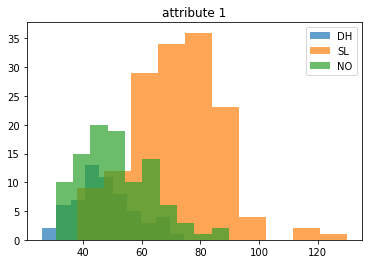

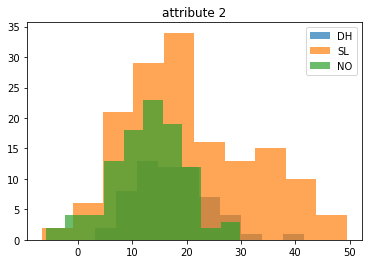

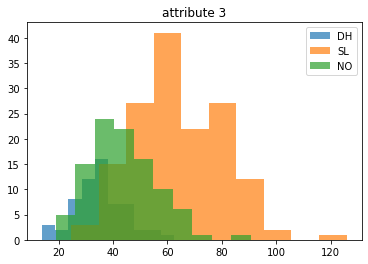

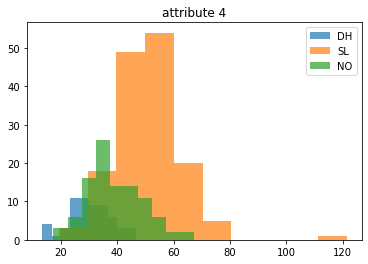

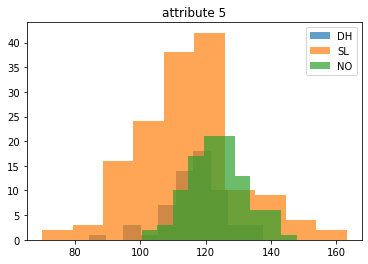

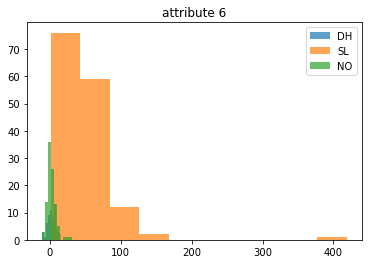

In [19]:
#Plot histograms for first 6 attributes, segmented by diagnosis
def create_hist(att_index:int, X, **kargs):
    """
    Function that plots histogram for a given feature, segmented by diease classification.

    :param att_index: an integer index that gives the wanted feature plotted
    :param X: an array that holds the training data, shape (patients, features)
    :param **kargs: any key arguments for the histogram plotting
    :return: None
    """ 
    plt.hist(X[dh,att_index], **kargs)
    plt.hist(X[sl,att_index], **kargs)
    plt.hist(X[no,att_index], **kargs)
    legend(["DH", "SL", "NO"])
    title(f"attribute {att_index+1}")
    plt.show()


for i in range(6):
    create_hist(i, X, alpha=0.7)
    

It is obvious from the histograms, that the population of patients with spondilolysthesis are quite different in their statistics, but there are big overlaps in all the attributes with the other two populations, and it would be difficult to point to a single attribute that allows the identification of that condition. PCA will come to the rescue. 

The other two populations, those patients with disk hernia and those who are healthy overlap almost perfectly in their distributions when each attribute is considered in isolation. It remains to be seen whether we will be able to separate the these to populations by considering all the attributes together. 


You might think that just using the scatter plot of two attributes solves this problem. Let's try it:

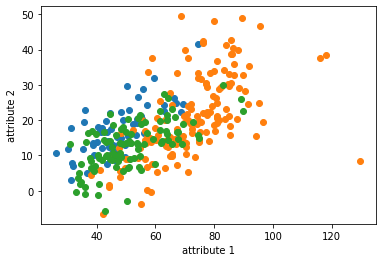

In [14]:
scatter(X[dh,0], X[dh,1])
scatter(X[sl,0], X[sl,1])
scatter(X[no,0], X[no,1])
legend(["DH", "SL", "NO"])
xlabel("attribute 1")
ylabel("attribute 2")
plt.show()

The groups are somewhat better separated, but we have arbitrarily chosen the first two attributes, and there is still considerable overlap.

We can view all the attributes plotted against one another by using seaborn's pairplot, but we first need to convert the data to a Pandas DataFrame.

In [23]:
#Import the needed packages
import pandas as pd
import seaborn as sn 

In [24]:
#Convert the list into a Dataframe with column headings
df = pd.DataFrame(X, columns=[f"attribute {i+1}" for i in range(X.shape[1]-1)] + ["diagnosis"])
df.head(5)

,attribute 1,attribute 2,attribute 3,attribute 4,attribute 5,attribute 6,diagnosis
0,63.03,22.55,39.61,40.48,98.67,-0.25,1.0
1,39.06,10.06,25.02,29.00,114.41,4.56,1.0
2,68.83,22.22,50.09,46.61,105.99,-3.53,1.0
3,69.30,24.65,44.31,44.64,101.87,11.21,1.0
4,49.71,9.65,28.32,40.06,108.17,7.92,1.0


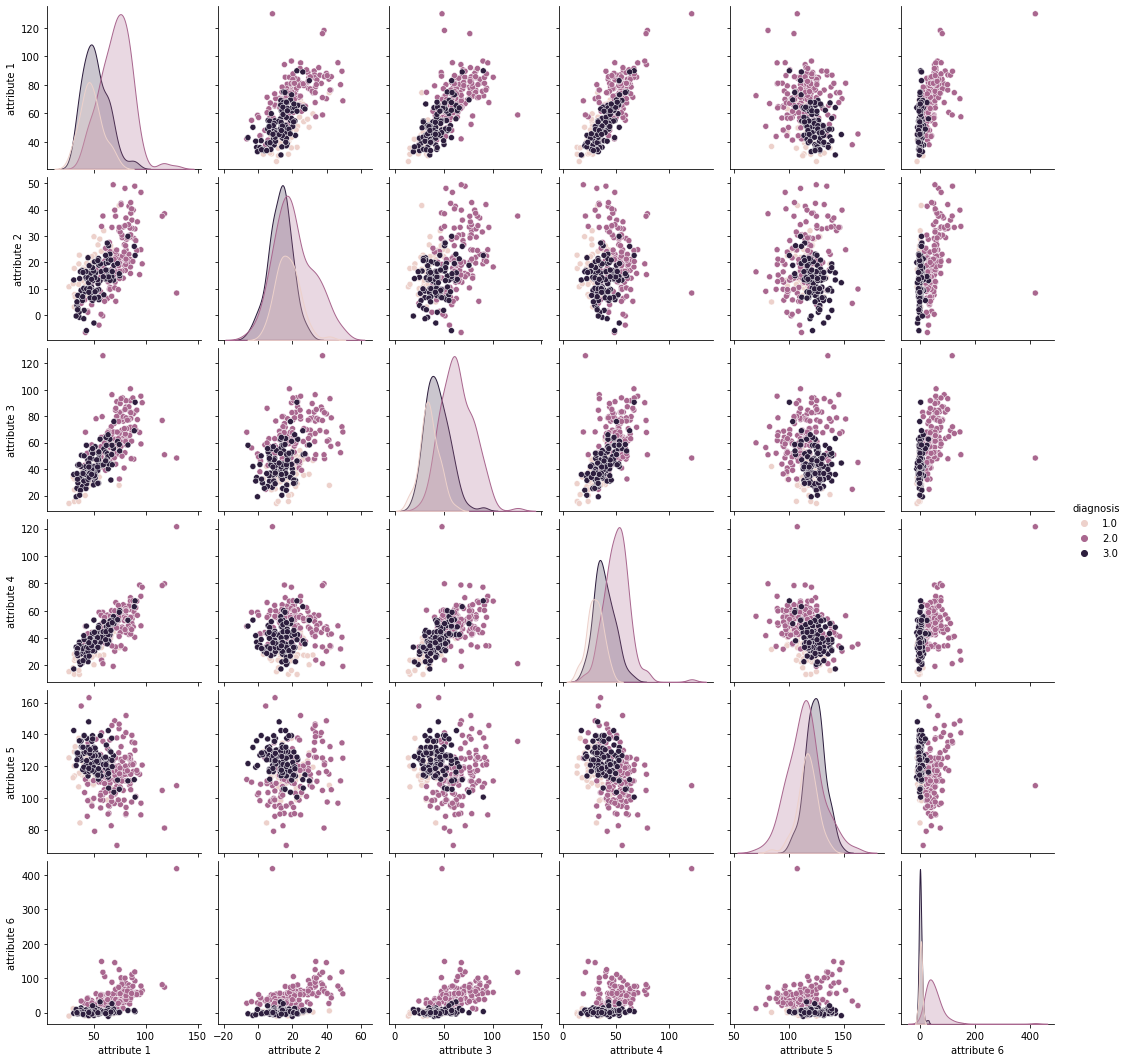

In [25]:
#Use Seaborn pairplot to visulaise the data
sn.pairplot(data=df, hue="diagnosis")

As can be seen, using the original attributes as axes for the data does not seperate the data into their diagnoses well. This is where PCA comes in...

## PCA theory

#### The optimal rotation of the data ellipsoid

What PCA tries to do, is to find linear combinations of the attributes which, when used as new variables, allow the best separation of the data. Another way of saying the same thing is to find new variables whose values "explain" the most variation in the data, in order. Yet another way is to imagine the data as an ellipsoidal cloud in the higher dimensional attribute-space, and finding the orthogonal axes of this ellipsoid, in order, first the "longest" axis, then the second longest, etc. 

A formal way of saying this is that first we are looking for a vector $w_1$, such that the data projected onto this vector has the largest variance, i.e. 

$$
w_1 = {\rm arg} \max_{w} \sum_i^N (X_i \cdot w)^2
$$

where $X_i$ is the vector corresponding to the attributes of patient $i$. This is equivalent to maximising 

$$
wX^T Xw
$$

which is achieved by the eigenvector of $X^T X$ with the largest eigenvalue. The second axis of the ellipsoid will be the eigenvector with the second largest eigenvalue, etc. 

Note that above we implicitly assumed that the mean of the data is zero along all attributes, so we will have to normalise the data to achieve this, i.e. subtract the mean value from each attribute. And since we are only interested in finding the directions of the orthogonal axes, it is also customary to multiply each attribute by a scalar so that their variances are unity. 

Before going further, let us write a function that normalises any data matrix, this will be useful later on!

In [26]:
def normalise(x):
    ndata,ndim = x.shape # obtain the number of rows and columns
    m= x.sum(axis=0)     # compute the mean along each column, and collect it into a vector
    #print m
    x0 = x - m[np.newaxis,:]/ndata # subtract the mean divided by the number of rows from each element
                                   # the "np.newaxis" construct creates identical rows from the same mean value

    s = np.sqrt((x0**2).sum(axis=0)/ndata) # now compute the standard deviation of each column
    #print x
    #print s
    ss = np.array([ tmp if tmp != 0 else 1 for tmp in s]) # if the standard deviation is zero, replace it with 1
                                                       # to avoid division by zero error
    x00 = x0 / ss[np.newaxis,:]    # divide each element by the corresponding standard deviation
    return x00                     # return the normalised data matrix

## Worked example

Having written the function, let us apply it to our data matrix X

In [27]:
X0 = normalise(X[:,0:6]) # we only normalise the attributes, so the first 6 columns, 
                         # not the last column, that's the diagnosis!

We can verify that its attributes now have zero mean:

In [28]:
X0.sum(axis=0)

array([ 7.77156117e-15, -3.23963079e-13, -1.11022302e-14,  4.01900735e-14,
       -6.09845507e-13, -6.85007606e-14])

close enough!

Now we form the $X^T X$ matrix (using the normalised data), and obtain its eigenvalues and eigenvectors:

In [30]:
# There are several ways to multiply matrices, depending on how they are created. 
# in the current case, using the matmul() function is one way. 
XTX = np.matmul(np.transpose(X0), X0) 


Now we compute the eigenvectors and eigenvalues. Indeed this calculator is simple to use!

In [31]:
evals,evecs = np.linalg.eigh(XTX)

The first object returned is an array of eigenvalues:

In [32]:
evals

array([1.53349541e-05, 1.01063819e+02, 1.46482960e+02, 2.35941802e+02,
       3.70320971e+02, 1.00619043e+03])

The second object is a matrix of  eiegnvectors, in corresponding order, so the one corresponding to the largest one is the last:

In [33]:
evecs[:,5]

array([ 0.53514087,  0.32357372,  0.4579713 ,  0.4459099 , -0.14351294,
        0.42397521])

Above, we said that we are interested in the eigenvector corresponding to the largest eigenvalue, that is the first in the list. Its elements are _weights_ of the various attributes, and we can see both positive weights (largest is the first one) and negative weights (fifth). 

Now remember that the SVD of a matrix $X$ gives you the eigenvectors of the matrix $X^TX$ and the corresponding singular values are the square roots of the corresponding eigenvalues. Let us verify this

In [34]:
U,s,V = np.linalg.svd(X0)
U.shape,s.shape,V.shape

((310, 310), (6,), (6, 6))

The matrices $U$ and $V$ contain the left and right singular vectors, and the array $s$ are the singular values

In [23]:
s**2

array([1.00619043e+03, 3.70320971e+02, 2.35941802e+02, 1.46482960e+02,
       1.01063819e+02, 1.53349544e-05])

Note how the order of the singular values is reversed. $V$ contains the singular vectors we are interested in:

In [24]:
V

array([[-5.35140872e-01, -3.23573718e-01, -4.57971304e-01,
        -4.45909899e-01,  1.43512940e-01, -4.23975209e-01],
       [ 2.17961800e-03, -5.27573744e-01, -9.28792528e-02,
         3.96157537e-01, -7.27735550e-01, -1.62772271e-01],
       [-9.60744914e-02, -6.48684038e-01,  1.52303832e-01,
         3.60291749e-01,  5.86002159e-01,  2.71244501e-01],
       [ 1.02797461e-01,  6.38522687e-03,  5.48120310e-01,
         1.27210907e-01,  1.74245827e-01, -8.01505966e-01],
       [-4.23475683e-01, -1.50555722e-01,  6.76759483e-01,
        -4.31495354e-01, -2.75762337e-01,  2.78863437e-01],
       [-7.17279733e-01,  4.16493956e-01, -2.22931275e-06,
         5.58607705e-01,  6.95399700e-06, -1.76475063e-05]])

Notice that the right singular eigenvectors are stored in $V$ as rows, e.g. the first row of $V$ matches the eigenvector above. 

## Viewing data in the eigenbasis

Time for magic. Let us plot the data in the rotated coordinate system, whose axes are the first two eigenvectors. In order to do this, we create the components of the rotated data, which are calld _principal components_:

In [25]:
X1 = np.matmul(X0,evecs[:,5])
X2 = np.matmul(X0,evecs[:,4])

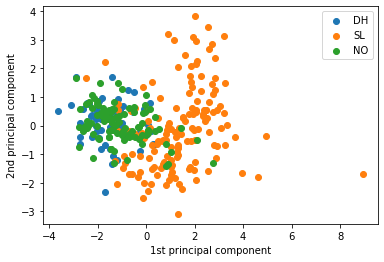

In [26]:
scatter(X1[dh], X2[dh])
scatter(X1[sl], X2[sl])
scatter(X1[no], X2[no])
xlabel("1st principal component")
ylabel("2nd principal component")
legend(["DH", "SL", "NO"])
plt.show()

Now the SL group separates quite cleanly from the DH and NO groups, with only a few outliers. Given how several of the weights in the first principal component are about the same size, we now undertand why considering a single or even a pair of attributes did not show such a clear picture. 

The DH and NO groups do not separate particularly well. We can take a look at the third principal component.

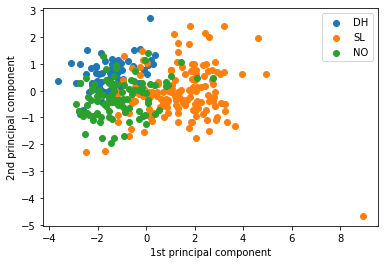

In [27]:
X3 = np.matmul(X0,evecs[:,3])
scatter(X1[dh], X3[dh])
scatter(X1[sl], X3[sl])
scatter(X1[no], X3[no])
xlabel("1st principal component")
ylabel("3rd principal component")
legend(["DH", "SL", "NO"])
plt.show()

The separation of the DH and NO groups is slightly better, but still not great. 

Let's now look a pairwise plot of the data transformed to the principle components.

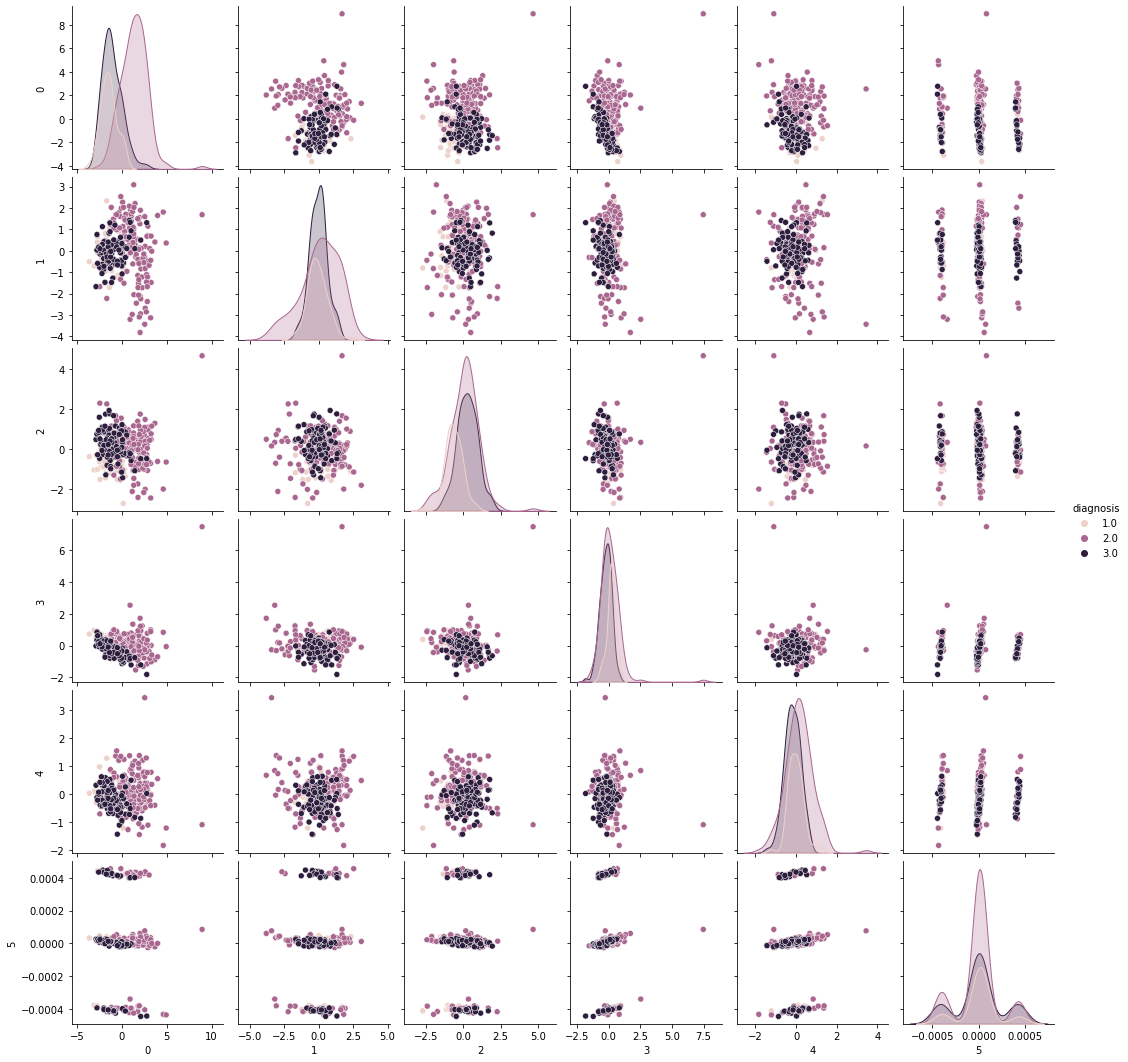

In [55]:
idx = evals.argsort()[::-1]   
eigenValues = evals[idx]
eigenVectors = evecs[:,idx]


X_pca = np.matmul(X0, eigenVectors)
df_pca1 = pd.concat([pd.DataFrame(X_pca), df.diagnosis], axis=1)


sn.pairplot(data=df_pca1, hue="diagnosis")


As you can see, the diagnoses are still not seperated that well... (although they are better than they were before).

Note this can also be done using sklearn.decomposition with the PCA package as shown below:

                  PC0       PC1       PC2       PC3       PC4       PC5
attribute 1  0.535141 -0.002180 -0.096074 -0.102797 -0.423476  0.717280
attribute 2  0.323574  0.527574 -0.648684 -0.006385 -0.150556 -0.416494
attribute 3  0.457971  0.092879  0.152304 -0.548120  0.676759  0.000002
attribute 4  0.445910 -0.396158  0.360292 -0.127211 -0.431495 -0.558608
attribute 5 -0.143513  0.727736  0.586002 -0.174246 -0.275762 -0.000007
attribute 6  0.423975  0.162772  0.271245  0.801506  0.278863  0.000018


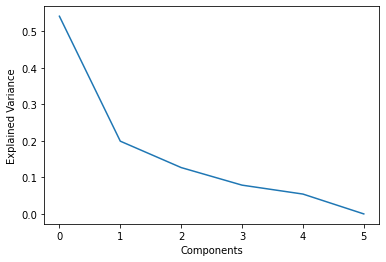

In [56]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plot


# You must normalize the data before applying the fit method
df_atts = df.drop(["diagnosis"], axis=1)
df_normalized=(df_atts - df_atts.mean()) / df_atts.std()
pca = PCA(n_components=df_atts.shape[1])
pca.fit(df_normalized)

# Reformat and view results
loadings = pd.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],
index=df_atts.columns)
print(loadings)

plot.plot(pca.explained_variance_ratio_)
plot.ylabel('Explained Variance')
plot.xlabel('Components')
plot.show()

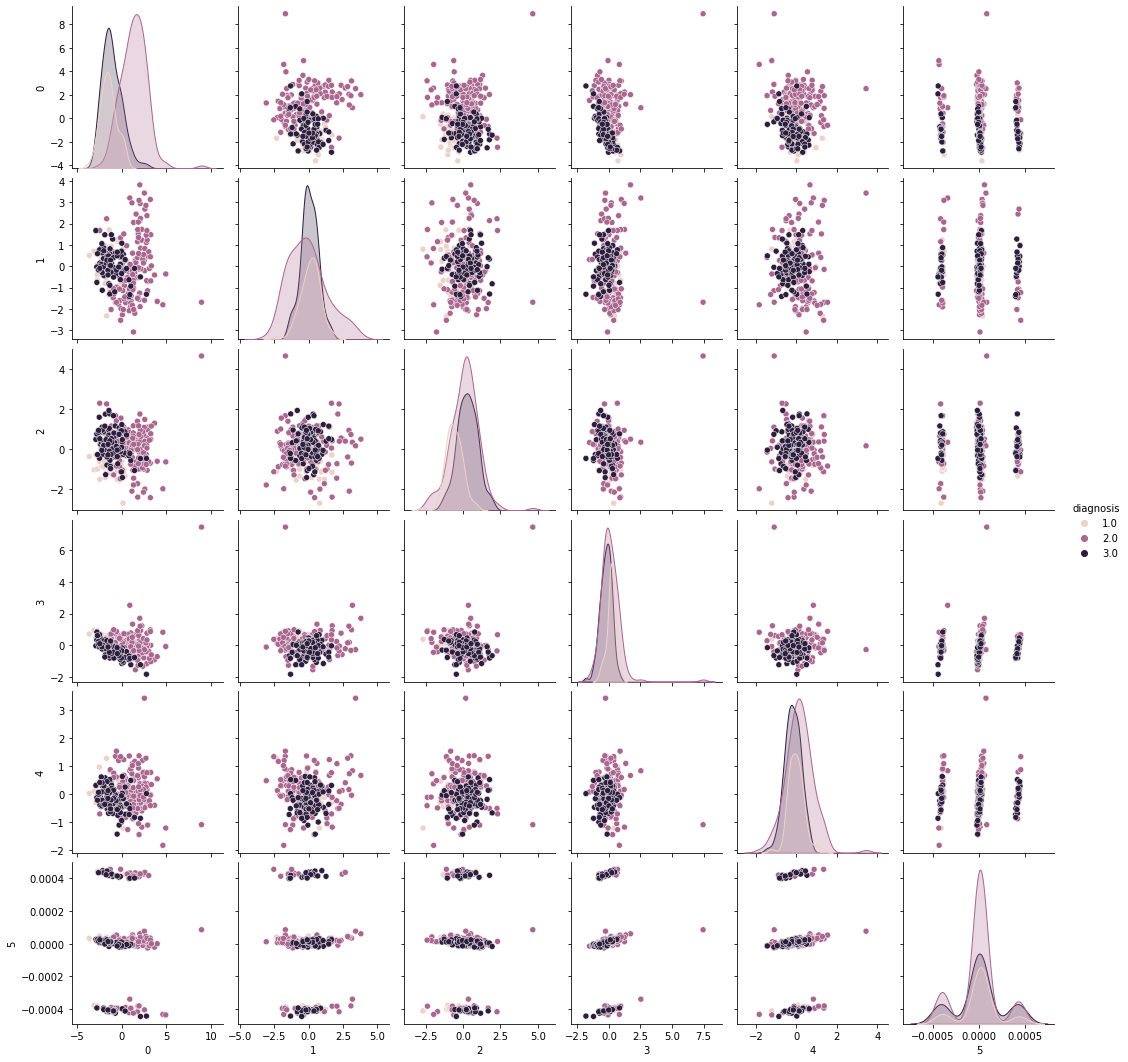

In [47]:
df_pca = pca.fit_transform(df_normalized)
df_pca = pd.concat([pd.DataFrame(df_pca), df.diagnosis], axis=1)


sn.pairplot(data=df_pca, hue="diagnosis")


## A high dimensional example

Next, we will be exploring a much larger dataset using PCA. It is also a medical example from the same [data source](http://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq). Gene expression levels have been measured for ~20,000 genes in ~800 patients, who have one of five different types of tumors: BRCA, KIRC, COAD, LUAD and PRAD. Is it possible to predict the type of tumor by considering the gene expression levels?

Use PCA to determine the linear combination of gene expression levels that allows the best separation of the five types of tumors.

Start by loading the data

In [91]:
X_hd = np.genfromtxt('cancer-gene-data2.csv', delimiter=',')

Originally there were more than 20,000 genes in the data set, and it would take quite a long time for your computer to solve such a large problem, so it was reduced by taking only every 2nd gene into account - hopefully we will not miss out on the important ones!

In [92]:
X_hd.shape

(801, 10266)

So we have 801 patients, and left with 10266 genes. This time, the data is large, so we will not form the $X^TX$ matrix, but use SVD straight away (first norlaising the data).

Normalise the training data for PCA:

In [93]:
X0_hd = normalise(X_hd)
print(X0_hd.sum(axis=0))

[ 9.53126467e-14  2.27906582e-12  1.92181826e-11 ... -7.37132577e-13
 -4.09744461e-12  1.91957561e-13]


In this example, the tumor types are in a separate file, converted to numbers 1-5:

In [95]:
tumor = np.genfromtxt('cancer-gene-labels.csv', delimiter=',')
print(tumor[:50])


U, s, V = np.linalg.svd(X0_hd)
print(U.shape, s.shape, V.shape)
diagnosis = tumor
BRCA = [index for index,value in enumerate(diagnosis) if value == 1]
KIRC = [index for index,value in enumerate(diagnosis) if value == 2]
COAD = [index for index,value in enumerate(diagnosis) if value == 3]
LUAD = [index for index,value in enumerate(diagnosis) if value == 4]
PRAD = [index for index,value in enumerate(diagnosis) if value == 5]

[1. 2. 1. 1. 3. 1. 4. 1. 3. 1. 3. 4. 1. 3. 3. 3. 2. 4. 4. 1. 3. 4. 2. 3.
 4. 2. 5. 3. 3. 3. 3. 3. 4. 3. 1. 3. 4. 2. 3. 3. 4. 1. 1. 4. 4. 3. 1. 5.
 3. 2.]


(801, 801) (801,) (10266, 10266)


Now we have the classes, time to visualise the seperation of classes on the original attribute axis.

In [113]:
def plot_scatter2D(compare_idx, X, label_str = "attribute", **kargs) -> None:
    '''
    function that plots 2D scatter plot, coloured by disease type

    parameters
    ----------
    comapare_idx: a typle or list of 2 indices to compare
    label_str: a string of prefix for labels
    X: list or array of training data, shape of (patients, features)
    **kargs: key arguments for scatter plots

    returns
    -------
    None
    '''

    scatter(X[BRCA,compare_idx[0]], X[BRCA,compare_idx[1]], **kargs)
    scatter(X[KIRC,compare_idx[0]], X[KIRC,compare_idx[1]], **kargs)
    scatter(X[COAD,compare_idx[0]], X[COAD,compare_idx[1]], **kargs)
    scatter(X[LUAD,compare_idx[0]], X[LUAD,compare_idx[1]], **kargs)
    scatter(X[PRAD,compare_idx[0]], X[PRAD,compare_idx[1]], **kargs)
    xlabel(f"{label_str} {compare_idx[0]}")
    ylabel(f"{label_str} {compare_idx[1]}")
    plt.show()

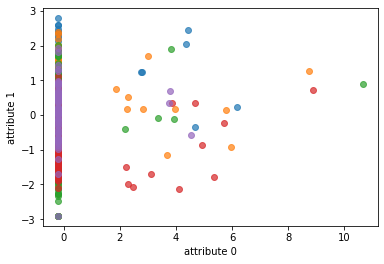

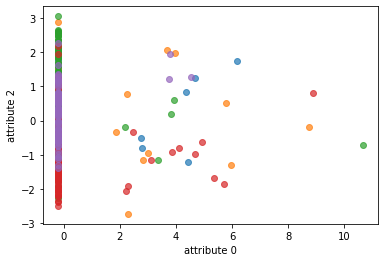

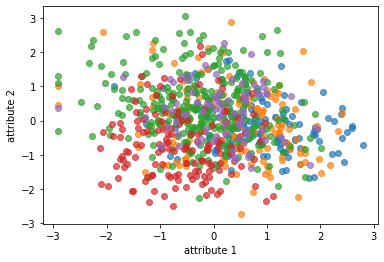

In [114]:
for i in range(3):
    for j in range(i,3):
        if i != j:
            plot_scatter2D((i,j), X0_hd, alpha = 0.7)

Not very informative... Let's apply PCA:

Let's look at using the first 4 eigenvectors as basis.

In [115]:
X_pca_hd = np.matmul(X0_hd, V.T[:,:4])

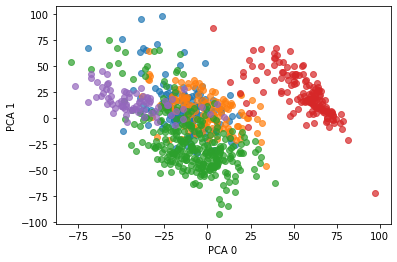

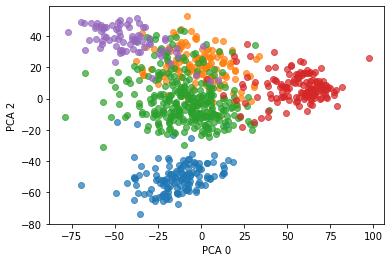

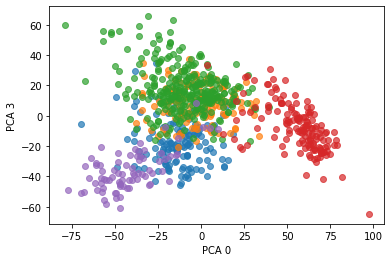

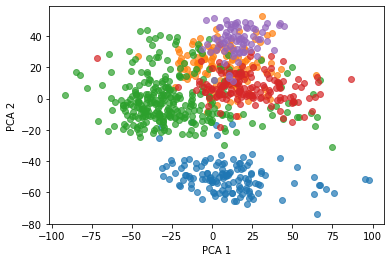

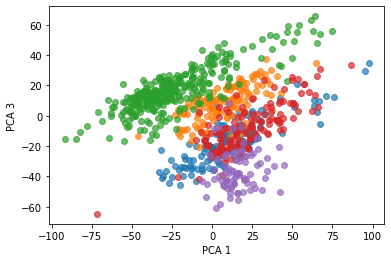

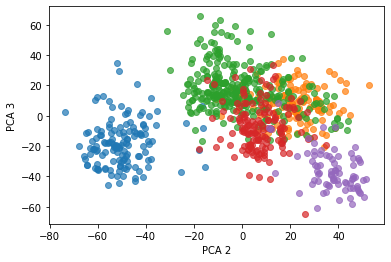

In [117]:
for i in range(X_pca_hd.shape[1]):
    for j in range(i+1, X_pca_hd.shape[1]):
        plot_scatter2D((i,j), X_pca_hd, label_str="PCA", alpha = 0.7)

That looks better...

We can see the classes seperating clearly in 3D:

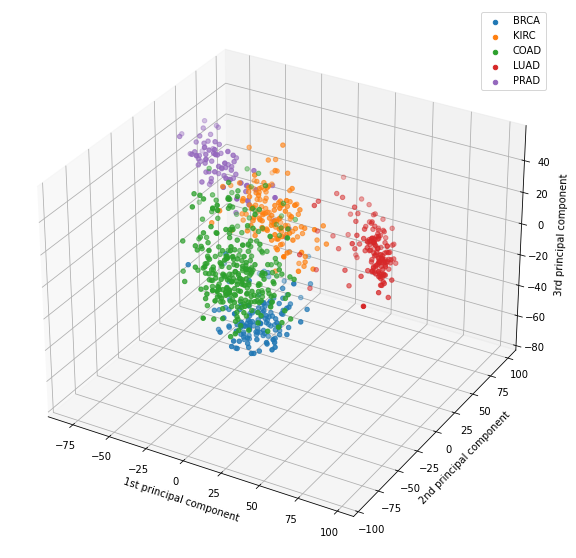

In [120]:

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(X_pca_hd[BRCA,0], X_pca_hd[BRCA,1], X_pca_hd[BRCA,2])
ax.scatter(X_pca_hd[KIRC,0], X_pca_hd[KIRC,1], X_pca_hd[KIRC,2])
ax.scatter(X_pca_hd[COAD,0], X_pca_hd[COAD,1], X_pca_hd[COAD,2])
ax.scatter(X_pca_hd[LUAD,0], X_pca_hd[LUAD,1], X_pca_hd[LUAD,2])
ax.scatter(X_pca_hd[PRAD,0], X_pca_hd[PRAD,1], X_pca_hd[PRAD,2])
ax.set_xlabel("1st principal component")
ax.set_ylabel("2nd principal component")
ax.set_zlabel("3rd principal component")
legend(["BRCA", "KIRC", "COAD", "LUAD", "PRAD"])
plt.show()